In [61]:
rm -rf ChestXray/test ChestXray/val ChestXray/train

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
from google.colab import files
files.upload()   # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harirude","key":"39b8a29800d225eac49c612393af62c1"}'}

In [64]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


In [65]:
!kaggle datasets download -d newra008/lung-mask-image-dataset
!unzip -o lung-mask-image-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: ChestXray/train/mask/cxrmask_9309.jpeg  
  inflating: ChestXray/train/mask/cxrmask_931.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9310.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9311.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9312.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9313.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9314.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9315.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9316.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9317.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9318.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9319.jpeg  
  inflating: ChestXray/train/mask/cxrmask_932.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9320.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9321.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9322.jpeg  
  inflating: ChestXray/train/mask/cxrmask_9323.jpeg  
  inflating: ChestXray/train/mask

In [66]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from PIL import Image

In [67]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [68]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides = 2)(x)

    return x

In [69]:
def decoder_block(inputs, skip_connections, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_connections = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_connections)
    x = tf.keras.layers.Concatenate()([x, skip_connections])

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [70]:
def unet_model(input_shape = (128, 128, 1), num_classes = 1):
    # input is 512x512 greyscale images
    # two classes: either background or lung area
    inputs = tf.keras.layers.Input(shape = input_shape)

    # Encoder
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(512, 3, padding = 'same')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(512, 3, padding = 'same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding = 'same', activation = 'sigmoid')(d4)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'U-Net')
    return model

In [71]:
unet = unet_model(input_shape = (128, 128, 1), num_classes = 1)
unet.summary(line_length=100)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 1)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_58 (Conv2D)          │ (None, 128, 128, 64)    │            640 │ input_layer_3[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_55 (Activation)  │ (None, 128, 128, 64)    │              0 │ conv2d_58[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d_12            │ (None, 64, 64, 64)      │              0 │ activation_55[0][0]     │
│ (MaxPooling2D)              │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_60 (Conv2D)          │ (None, 64, 64, 128)     │         73,856 │ max_pooling2d_12[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_57 (Activation)  │ (None, 64, 64, 128)     │              0 │ conv2d_60[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d_13            │ (None, 32, 32, 128)     │              0 │ activation_57[0][0]     │
│ (MaxPooling2D)              │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_62 (Conv2D)          │ (None, 32, 32, 256)     │        295,168 │ max_pooling2d_13[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_59 (Activation)  │ (None, 32, 32, 256)     │              0 │ conv2d_62[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d_14            │ (None, 16, 16, 256)     │              0 │ activation_59[0][0]     │
│ (MaxPooling2D)              │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_64 (Conv2D)          │ (None, 16, 16, 512)     │      1,180,160 │ max_pooling2d_14[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_61 (Activation)  │ (None, 16, 16, 512)     │              0 │ conv2d_64[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d_15            │ (None, 8, 8, 512)       │              0 │ activation_61[0][0]     │
│ (MaxPooling2D)              │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_65 (Conv2D)          │ (None, 8, 8, 512)       │      2,359,808 │ max_pooling2d_15[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_62 (Activation)  │ (None, 8, 8, 512)       │              0 │ conv2d_65[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_66 (Conv2D)          │ (None, 8, 8, 512)       │      2,359,808 │ activation_62[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_63 (Activation)  │ (None, 8, 8, 512)       │    

 Total params: 17,409,409 (66.41 MB)

 Trainable params: 17,409,409 (66.41 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
IMG_SIZE = (128, 128)

def load_dataset(img_dir, mask_dir, img_limit = 100):
    X, y = [], []
    files = os.listdir(img_dir)
    for idx in range(min(img_limit, len(files))):
        img = Image.open(os.path.join(img_dir, files[idx])).convert("L").resize(IMG_SIZE)

        mask_file = files[idx].replace('.png', '.jpeg').replace('image', 'mask')
        mask = Image.open(os.path.join(mask_dir, mask_file)).convert("L").resize(IMG_SIZE)

        X.append(np.array(img, dtype=np.float32) / 255.0)
        y.append((np.array(mask) > 0).astype(np.uint8))

    return np.expand_dims(np.array(X), -1), np.expand_dims(np.array(y), -1)

In [73]:
img_train = '/content/ChestXray/train/image/'
mask_train = '/content/ChestXray/train/mask/'

X, y = load_dataset(img_train, mask_train, 300)

In [74]:
print(set(np.unique(y)) <= {0, 1})

True


In [75]:
print(X.shape, X.dtype)
print(y.shape, y.dtype)
print(np.unique(y))

(300, 128, 128, 1) float32
(300, 128, 128, 1) uint8
[0 1]


In [76]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)

    # dice_score = intersection / union
    # dice_loss = 1 - dice_score (0 -> perfect segmentation)
    return 1 - (2 * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

unet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
)

In [77]:
print(X.shape)


(300, 128, 128, 1)


In [78]:
history = unet.fit(
    X, y,
    epochs=15,
    batch_size=8,     # important for 512×512
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 341s 11s/step - loss: 1.3445 - val_loss: 1.2662 - learning_rate: 1.0000e-04
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 385s 11s/step - loss: 1.1527 - val_loss: 0.9941 - learning_rate: 1.0000e-04
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 396s 12s/step - loss: 0.9172 - val_loss: 0.8784 - learning_rate: 1.0000e-04
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 333s 11s/step - loss: 0.7695 - val_loss: 0.8487 - learning_rate: 1.0000e-04
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 332s 11s/step - loss: 0.5775 - val_loss: 0.5093 - learning_rate: 1.0000e-04
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 402s 12s/step - loss: 0.4401 - val_loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 382s 12s/step - loss: 0.4038 - val_loss: 0.4072 - learning_rate: 1.0000e-04
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 354s 11s/step - loss: 0.3763 - val_loss: 0.3851 - learning_rate: 1.0000e-04
Epoch 9/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 343s 11s/step - loss: 0.3294 - val_loss: 0.3594 - 

In [82]:
unet.save_weights("/content/drive/MyDrive/best_unet.weights.h5")


In [80]:
img_val = '/content/ChestXray/val/image/'
mask_val = '/content/ChestXray/val/mask/'

X_val, y_val = load_dataset(img_val, mask_val)

In [81]:
y_prob = unet.predict(X_val, batch_size = 1)
y_pred = (y_prob > 0.5).astype(np.uint8)

100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step


In [83]:
def dice_score(y_true, y_pred, smooth=1):
    y_true = y_true.astype(np.uint8).flatten()
    y_pred = y_pred.astype(np.uint8).flatten()
    inter = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

dice = np.mean([dice_score(y_val[i], y_pred[i]) for i in range(len(y_val))])
print("Dice:", dice)

Dice: 0.8920898669197312


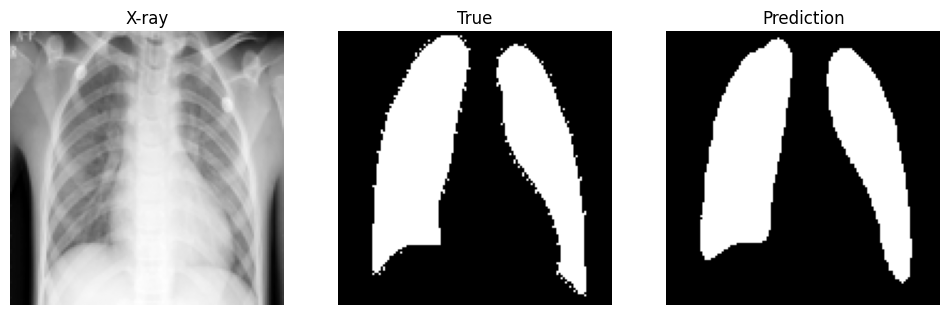

In [84]:
import matplotlib.pyplot as plt

i = 6# pick any index
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("X-ray")
plt.imshow(X_val[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True")
plt.imshow(y_val[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(y_pred[i].squeeze(), cmap="gray")
plt.axis("off")

plt.show()

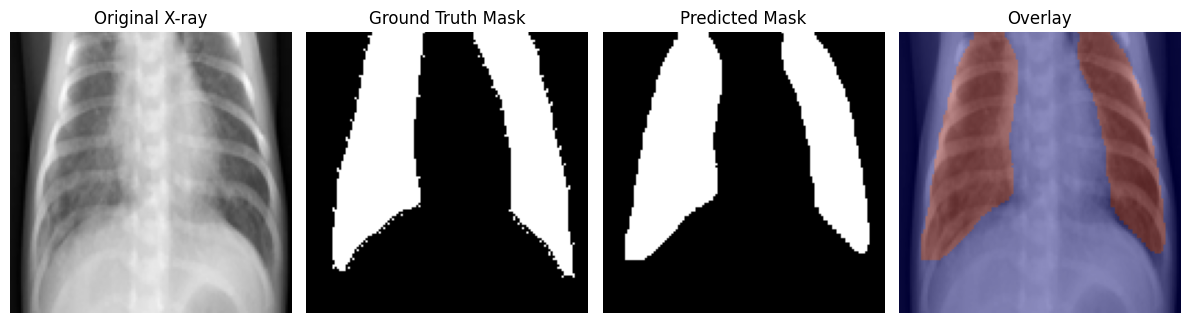

In [85]:
import random
import matplotlib.pyplot as plt

# select a random validation image
i = random.randint(0, len(X_val) - 1)

# load image
img = X_val[i]

# predict segmentation
pred = unet.predict(img[np.newaxis, ...], verbose=0)[0]

# binarise prediction
seg_map = (pred > 0.26).astype(np.uint8)

# plotting
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("Original X-ray")
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth Mask")
plt.imshow(y_val[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Predicted Mask")
plt.imshow(seg_map.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img.squeeze(), cmap="gray")
plt.imshow(seg_map.squeeze(), cmap="jet", alpha=0.4)
plt.axis("off")

plt.tight_layout()
plt.show()


## Thresholding Model

In [86]:
img_test = '/content/ChestXray/test/image/'
mask_test = '/content/ChestXray/test/mask/'

X_test, y_test = load_dataset(img_test, mask_test, 100)

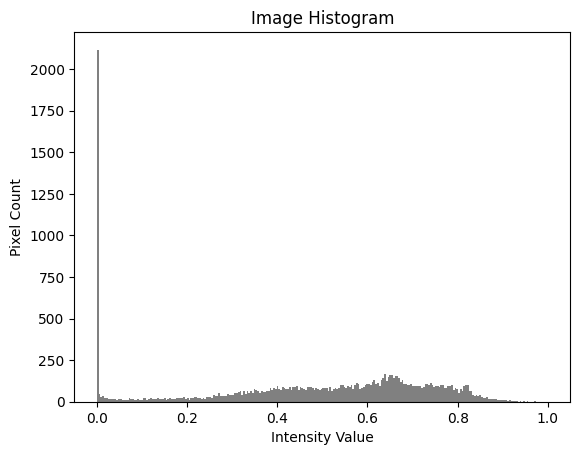

In [87]:
import matplotlib.pyplot as plt

plt.hist(X_test[0].ravel(), bins=256, range=(0, 1), color='gray')
plt.title("Image Histogram")
plt.xlabel("Intensity Value")
plt.ylabel("Pixel Count")
plt.show()

In [88]:
def load_threshold_result(image, threshold_low=0.18, threshold_high=0.6):
    h, w, _ = image.shape
    result = np.zeros((h, w, 1), dtype=np.float32)

    mask = (image > threshold_low) & (image < threshold_high)
    result[mask] = 1

    return result


In [89]:
y_pred_threshold = []
for i in range(len(y_test)):
    y_pred_threshold.append(load_threshold_result(X_test[i]))

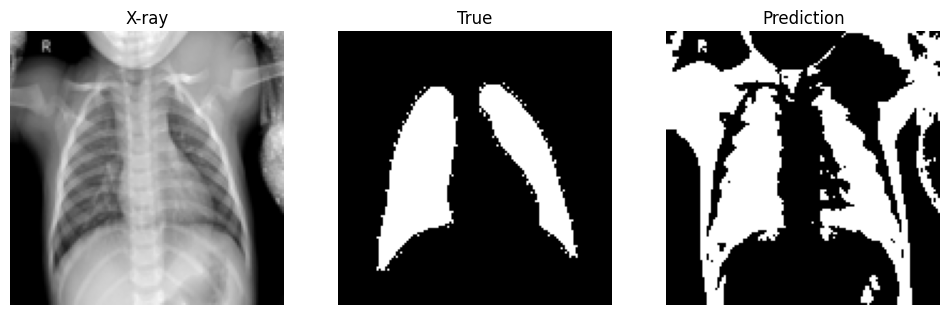

In [90]:
i = 0 # random value
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("X-ray")
plt.imshow(X_test[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True")
plt.imshow(y_test[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(y_pred_threshold[i].squeeze(), cmap="gray")
plt.axis("off")

plt.show()

In [91]:
dice = np.mean([dice_score(y_test[i], y_pred_threshold[i]) for i in range(len(y_test))])
print("Dice:", dice)

Dice: 0.5951744632567245


### K-Means method

In [92]:
from sklearn.cluster import KMeans

kmeans_pred = []

for i in range(len(X_test)):
    img = X_test[i].squeeze() # (H, W, 1) -> (H, W)
    X = img.reshape(-1, 1)    # (H, W) -> (H*W, 1)

    kmeans = KMeans(n_clusters = 2, n_init = 30)
    labels = kmeans.fit_predict(X).reshape(img.shape)

    means = [img[labels == c].mean() for c in range(2)]
    fg_cluster = 1 - np.argmax(means)

    mask_pred = (labels == fg_cluster).astype(np.uint8)
    kmeans_pred.append(mask_pred)

kmeans_pred = np.array(kmeans_pred)

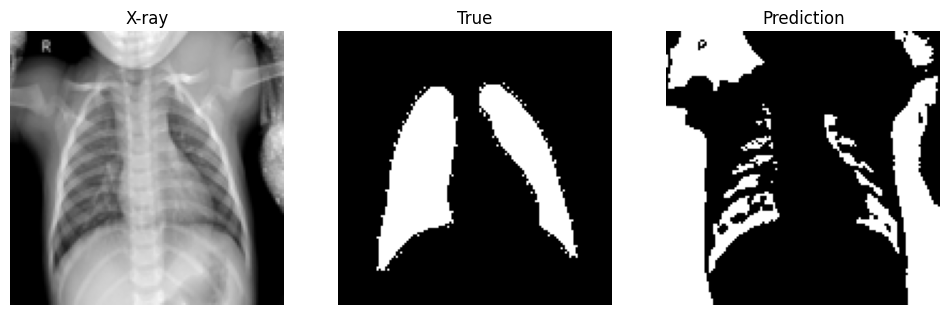

In [93]:
import matplotlib.pyplot as plt

i = 0 # random value
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("X-ray")
plt.imshow(X_test[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True")
plt.imshow(y_test[i].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(kmeans_pred[i], cmap="gray")
plt.axis("off")

plt.show()

In [94]:
dice = np.mean([dice_score(y_test[i], kmeans_pred[i]) for i in range(len(y_test))])
print("Dice:", dice)

Dice: 0.5531626017838817
